In [1]:
from scripts import preprocessing_old
from scripts import predict_stromfluss
from scripts import preprocessing_weatherdata
from scripts import preprocessing_plannedProduction
from scripts import preprocessing_trade_price_consumption
from bda import bda_utilities
import pandas as pd
import numpy as np
import os.path

## Preprocessing

Load and format power flow.

In [2]:
df = predict_stromfluss.read_data_stromfluss('./data/stromfluss')
df = predict_stromfluss.preprocessing_stromfluss(df)

In [3]:
def create_net_columns(df):
    countries = ["NL", "CHE", "DNK", "CZE", "LUX", "SWE", "AUT", "FRA", "PL"]
    for country in countries:
        im_key = country + "_IM"
        ex_key = country + "_EX"
        df[country]=df[im_key] +df[ex_key]
        df = df.drop(columns=[im_key,ex_key])
    return df


In [4]:
df = create_net_columns(df)
df = df.rename(columns={"Date":"date"})


Load and format weather data. 

In [5]:
df_weather = preprocessing_weatherdata.import_weatherData()
df_weather = df_weather[df_weather['date'].dt.year >= 2015]
df_weather.head()

,date,DE_av_windspeed_ms_north,DE_percip_mm_north,DE_sun_hrs_north,DE_av_windspeed_ms_south,DE_percip_mm_south,DE_sun_hrs_south,DK_sun_hrs,DK_av_windSpeed_ms,CZ_av_temperatureChange,CZ_av_windSpeed,FR_av_temperatureChange,FR_av_windSpeed
48942,2015-01-01,7.336364,-112.171429,2.980412,2.880556,0.065789,2.053026,0.0,8.4,NaN,NaN,NaN,NaN
48943,2015-01-02,10.930303,-112.431429,0.984794,5.925714,3.997368,0.451316,2.0,12.0,NaN,NaN,NaN,NaN
48944,2015-01-03,8.972727,-111.354286,0.045118,4.957143,14.647368,0.111895,2.5,8.2,NaN,NaN,NaN,NaN
48945,2015-01-04,7.393939,-113.365714,3.463676,4.774286,1.015789,1.045184,5.2,6.0,NaN,NaN,NaN,NaN
48946,2015-01-05,5.606061,-113.351429,0.894176,3.035294,0.168421,4.415789,0.3,3.2,NaN,NaN,NaN,NaN


In [6]:
#make hourly
df_weather = bda_utilities.make_hourly(df_weather)

In [7]:
# Weather data for CZ and FR only start in 2017, so we drop them
df_weather.set_index("date").iloc[:,8:].plot()
df_weather = df_weather.drop(columns=df_weather.columns[8:])

In [8]:
# Percipitation has probably no effect on power flow, so we drop those as well 
df_weather = df_weather.drop(columns=[col for col in df_weather.columns if "percip" in col])

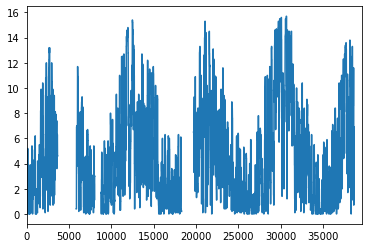

In [9]:
# DK sun hours has great portions of missing values, so we drop it . 
df_weather['DK_sun_hrs'].plot()
df_weather = df_weather.drop(columns=['DK_sun_hrs'])

Create a df containing a 24 lag for power flow values. 

In [11]:
df_24h_lag = df.copy()
df_24h_lag.set_index("date", inplace=True)
df_24h_lag = df_24h_lag.shift(+24)

def custom_column_mapper(df, append_str):
    cols = df.columns
    mapper = {}
    for col in cols:
        mapper[col]=col + append_str
    return mapper

df_24h_lag.rename(columns=custom_column_mapper(df_24h_lag, "-24h"), inplace=True)
df_24h_lag.reset_index(inplace=True)

Check other external information: trade, price, and consumption

In [12]:
# All this data is only until 2017. Is there more recent data? 
# For now, don't include these in the master dataframe

#df_consumption = preprocessing_trade_price_consumption.import_consumptionData()
#df_consumption.plot()

#df_price = preprocessing_trade_price_consumption.import_priceData()
#df_price.set_index("date").plot()

#df_trade = preprocessing_trade_price_consumption.import_foreignTradeData()
#df_trade.set_index("date").plot()

Make master dataframe containing all the information. 

In [13]:
df_master = df.copy()
df_master = df_master.merge(df_24h_lag)
df_master = df_master.merge(df_weather)

# split up datetime information, keep date as index for easier manipulation
df_master.set_index(['date'], append=True, inplace=True, drop=False)
df_master = bda_utilities.split_datetime(df_master)


In [14]:
# move datetime columns to the front for readibility

# It is bugged, i don't know why 
def move_columns_to_front(df, front_column_names): 
    '''
    Returns a list with reordered column names 
    '''
    columns = list(df.columns)
    for col in front_column_names:
        if col not in columns:
            front_column_names.remove(col) 
    for col in columns:
        if col in front_column_names:
            columns.remove(col)
    result = front_column_names + columns
    return result

# Static hotfix
def move_columns_to_front_static(df, front_column_names):
    result = move_columns_to_front(df, front_column_names)
    result.pop(-1)
    result.pop(-1)
    return result
    

column_order = move_columns_to_front_static(df_master, front_column_names=["year","month","weekday","hour","timestamp"])
df_master = df_master.loc[:,column_order]

In [15]:
# Save to data 
df_master.to_csv("./data/df_master.csv")

In [16]:
df_test = pd.read_csv("./data/df_master.csv", index_col=[0,1])
df_test.head()

,,year,month,weekday,hour,timestamp,NX,NL,CHE,DNK,CZE,...,CZE-24h,LUX-24h,SWE-24h,AUT-24h,FRA-24h,PL-24h,DE_av_windspeed_ms_north,DE_sun_hrs_north,DE_av_windspeed_ms_south,DE_sun_hrs_south
,date,,,,,,,,,,,,,,,,,,,,,
0,2015-06-01 00:00:00,2015,6,1,0,1.433117e+09,7279.0,3932.0,145.0,-272.0,554.0,...,NaN,NaN,NaN,NaN,NaN,NaN,4.535484,6.021697,3.65,3.698263
1,2015-06-01 01:00:00,2015,6,1,1,1.433120e+09,7167.0,4014.0,261.0,-141.0,469.0,...,NaN,NaN,NaN,NaN,NaN,NaN,4.535484,6.021697,3.65,3.698263
2,2015-06-01 02:00:00,2015,6,1,2,1.433124e+09,6667.0,3864.0,103.0,-326.0,422.0,...,NaN,NaN,NaN,NaN,NaN,NaN,4.535484,6.021697,3.65,3.698263
3,2015-06-01 03:00:00,2015,6,1,3,1.433128e+09,6413.0,4242.0,42.0,-262.0,235.0,...,NaN,NaN,NaN,NaN,NaN,NaN,4.535484,6.021697,3.65,3.698263
4,2015-06-01 04:00:00,2015,6,1,4,1.433131e+09,5347.0,4292.0,-127.0,-582.0,161.0,...,NaN,NaN,NaN,NaN,NaN,NaN,4.535484,6.021697,3.65,3.698263


In [17]:
#df.iloc[:,10]

## Sequence Prediction with LTSM

In [118]:
# Preprocessing master df for easier manipulation 
def make_target_columns_first(df):
    cols = [col for col in df.columns]
    country_codes = ["NX","NL","CHE","DNK","CZE","LUX","SWE",'AUT', "FRA", "PL"]
    cols = country_codes + cols
    cols = list(dict.fromkeys(cols))
    return cols

new_column_order = make_target_columns_first(df_master)
df = df_master[new_column_order].copy()
df.head()
df_NL= df.drop(df.columns[[0,2,3,4,5,6,7,8,9]], axis=1)

In [106]:
# There are data points missing / duplicated. We will drop those days. 
from datetime import timedelta

def find_missing_rows(df):
    last_timestamp = df.iloc[0].name[1]
    index_list = []
    for index, row in df.iterrows():       
        current_timestamp = index[1]
        if(current_timestamp != (last_timestamp + timedelta(hours=1))):
            index_list.append(index[0])
        last_timestamp = current_timestamp
    index_list.remove(0)
    return index_list

def find_days_with_missing_hours(df):
    index_list = find_missing_rows(df)
    dates = []
    for idx in index_list:
        dates.append(df.iloc[idx].name[1].date())
    dates = list(dict.fromkeys(dates))
    return dates

def get_delete_indices(df, missing_days):
    delete_indices = []
    for day in missing_days:
        day = str(day)
        idx = df.reset_index(level=0)[day]["level_0"].values
        delete_indices.extend([x for x in idx])
    return delete_indices



In [119]:
print(len(df_NL))
idxs = get_delete_indices(df_NL, find_days_with_missing_hours(df))
df_NL.drop(index=idxs, inplace=True)
print(len(df_NL))

35120
34920


In [120]:
from sklearn.preprocessing import MinMaxScaler  

def scale_dataframe(dataframe):
    # load dataset
    #dataset = dataframe.copy()
    values = dataframe.values
    # ensure all data is float
    values = values.astype('float32')
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    # frame as supervised learning
    
    return (scaler, scaled )


scaler, scaled = scale_dataframe(df_NL)


In [121]:
# split into train and test sets
values = scaled

# train until may until including april 2019 
training_entries = len(df.reset_index(level=0, drop=True)[:'2019-04-30']) 
# Ignore first 24 entries, because we don't know the prior day values 
train = values[24:training_entries, :]
test = values[training_entries:, :]
train[:,0].shape

(34304,)

In [201]:
# split into train and test sets
values = scaled

# train until may until including april 2019 
training_entries = len(df.reset_index(level=0, drop=True)[:'2019-04-30']) 
# Ignore first 24 entries, because we don't know the prior day values 
train = values[24:training_entries, :]
test = values[training_entries:, :]
# split into input and outputs
train_X, train_y = train[:, 1:], train[:, 0]
test_X, test_y = test[:, 1:], test[:, 0]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0] , 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
# reshape output to be 3D [samples, timesteps, features]
#train_y = train_y.reshape((train_y.shape[0], 1, train_y.shape[1]))
#test_y = test_y.reshape((test_y.shape[0], 1, test_y.shape[1]))

#reshape output to be 3D for single feature dimension
train_y = train_y.reshape((train_y.shape[0], 1, 1))
test_y = test_y.reshape((test_y.shape[0], 1, 1))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(34304, 1, 19) (34304, 1, 1) (592, 1, 19) (592, 1, 1)


In [123]:
from keras.models import Sequential  
from keras.layers import Dense  
from keras.layers import LSTM  
from keras.layers import Dropout 
from matplotlib import pyplot
from pandas import concat
from numpy import concatenate

In [199]:
model = Sequential()  
model.add(LSTM(units=120, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))  
model.add(Dropout(0.2))  
model.add(LSTM(units=120, return_sequences=True)) 
model.add(Dropout(0.2)) 
model.add(Dense(units = 1))  
model.compile(optimizer = 'adam', loss = 'mean_squared_error')  

In [ ]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=50, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

Train on 34304 samples, validate on 592 samples
Epoch 1/50
 - 9s - loss: 0.0228 - val_loss: 0.0670
Epoch 2/50
 - 4s - loss: 0.0108 - val_loss: 0.0584
Epoch 3/50
 - 4s - loss: 0.0103 - val_loss: 0.0547
Epoch 4/50
 - 4s - loss: 0.0099 - val_loss: 0.0533
Epoch 5/50
 - 4s - loss: 0.0094 - val_loss: 0.0503
Epoch 6/50
 - 4s - loss: 0.0091 - val_loss: 0.0479
Epoch 7/50
 - 4s - loss: 0.0089 - val_loss: 0.0458
Epoch 8/50


In [193]:
yhat = model.predict(test_X)
yhat.shape

(592, 1, 1)

In [194]:
test_X = test_X.reshape((test_X.shape[0] * test_X.shape[1], test_X.shape[2]))
yhat = yhat.reshape((yhat.shape[0] * yhat.shape[1], yhat.shape[2]))

inv_yhat = concatenate((yhat, test_X), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
# invert scaling for actual
print(test_y.shape)
#test_y = test_y.reshape(test_y.shape[0], 1)

test_y = test_y.reshape((test_y.shape[0] * test_y.shape[1], test_y.shape[2]))
inv_y = concatenate((test_y, test_X), axis=1)
inv_y = scaler.inverse_transform(inv_y)




(592, 1, 1)


In [195]:
inv_y[:,0]

array([   63.000084,   788.00006 ,   806.0001  ,   353.00006 ,
         224.9999  ,    65.00009 ,  -688.00006 , -1176.      ,
        -838.00006 ,  -552.00006 ,  -663.0002  ,  -696.00006 ,
        -404.0001  ,   -61.000072,   328.99994 ,  1194.0001  ,
        1116.0002  ,   553.9998  ,   361.00012 ,    66.0001  ,
          28.999884,   494.99976 ,  -138.99995 ,   659.9999  ,
        1991.9996  ,  2634.9998  ,  2185.      ,  2156.      ,
        2006.0004  ,  1915.0001  ,  1623.9998  ,  2050.9998  ,
        1752.      ,  1439.9999  ,   945.9998  ,   733.99976 ,
         616.9999  ,   775.00024 ,   839.00006 ,   706.0001  ,
        1131.9998  ,  1568.      ,  1466.9998  ,  1037.9998  ,
        1402.9999  ,  1323.      ,  1356.9996  ,  1153.0002  ,
         918.99994 ,  1027.      ,  -134.99994 ,    93.99998 ,
         217.00012 ,   168.00012 ,    75.99988 ,  -358.0001  ,
         128.9999  ,   743.00006 ,  1625.0001  ,  2207.9998  ,
        2309.      ,  2547.0002  ,  2834.9998  ,  2664.

In [196]:
from math import sqrt
from sklearn.metrics import mean_squared_error

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y[:,0], inv_yhat[:,0]))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1962.651


In [197]:
plotting_df = pd.DataFrame({"y":inv_y[:,0],"yhat":inv_yhat[:,0]})

(-10000, 10000)

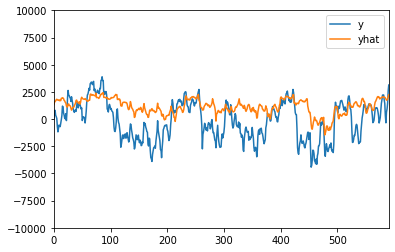

In [198]:
ax = plotting_df.plot()
ax.set_ylim(-10000,10000)